In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import shutil
from tqdm import tqdm
import os
import torch

In [2]:
! pip install rembg -q

In [3]:
import zipfile


with zipfile.ZipFile('/kaggle/input/platesv2/plates.zip', 'r') as zip_obj:
   # Extract all the contents of zip file in current directory
   zip_obj.extractall('/kaggle/working/')

In [4]:
data_root = '/kaggle/working/plates/'

In [5]:
from pathlib import Path
from rembg import remove, new_session

In [6]:
session = new_session()

labels = ['cleaned', 'dirty']

for dir_name in ['train', 'val']:
    for l in labels:
        os.makedirs(os.path.join(dir_name, l), exist_ok=True)

for l in labels:
    for i, file in enumerate(tqdm(Path(f"/kaggle/working/plates/train/{l}").glob('*.jpg'))):
        input_path = str(file)
        if i % 5 == 0:
            output_path = f"/kaggle/working/val/{l}/{file.stem}.jpg"
        else:
            output_path = f"/kaggle/working/train/{l}/{file.stem}.jpg"
        with open(input_path, 'rb') as i:
            with open(output_path, 'wb') as o:
                input = i.read()
                output = remove(input, session=session)
                o.write(output)

100%|████████████████████████████████████████| 176M/176M [00:00<00:00, 213GB/s]
20it [00:15,  1.33it/s]
20it [00:18,  1.10it/s]


In [7]:
os.makedirs("test/unknown", exist_ok=True)

# session = new_session()

for i, file in enumerate(tqdm(Path("/kaggle/working/plates/test").glob('*.jpg'))):
        input_path = str(file)
        output_path = f"/kaggle/working/test/unknown/{file.stem}.jpg"
        with open(input_path, 'rb') as i:
            with open(output_path, 'wb') as o:
                input = i.read()
#                 output = remove(input, session=session)
                o.write(input)

744it [00:00, 7441.85it/s]


In [8]:
from torchvision import transforms, datasets

transforms_train = transforms.Compose([
    # data augmentation
    transforms.Resize(232),
    transforms.RandomRotation(40),
    transforms.CenterCrop((224, 224)),
    transforms.RandomResizedCrop(224, scale=(0.3, 0.7)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    # converting to tensor
    transforms.ToTensor(),
    # ResNet normalization
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

transforms_val = transforms.Compose([
    # resizing
    transforms.Resize(300),
    transforms.CenterCrop((224, 224)),
    # converting to tensor
    transforms.ToTensor(),
    # ResNet normalization
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


transforms_test = transforms.Compose([
    # resizing
    transforms.Resize(300),
    transforms.CenterCrop((224, 224)),
    # converting to tensor
    transforms.ToTensor(),
    # ResNet normalization
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


train_dataset = datasets.ImageFolder("train", transforms_train)
val_dataset = datasets.ImageFolder("val", transforms_val)
test_dataset = datasets.ImageFolder("test", transforms_test)

In [9]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

In [10]:
import matplotlib.pyplot as plt


def get_image_and_label_batch(dataloader, n, labels=None):
    plt.figure(figsize=(3 * min(n, 8), 4 * (n // 8 + 1)))
    if labels is None:
        images, labels = next(iter(dataloader))
        labels = labels.unsqueeze(1).int()
    else:
        images, _ = next(iter(dataloader))
    for i, (img, l) in enumerate(zip(images[:n], labels[:n])):
        ax = plt.subplot(n // 8 + 1, min(n, 8), i + 1)
        img = img.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        plt.imshow(img)
        plt.title(l.item())
        plt.axis("off")

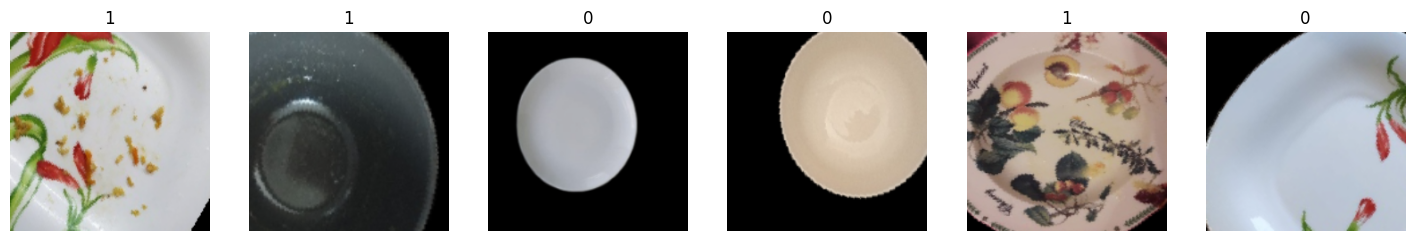

In [11]:
get_image_and_label_batch(train_dataloader, 6)

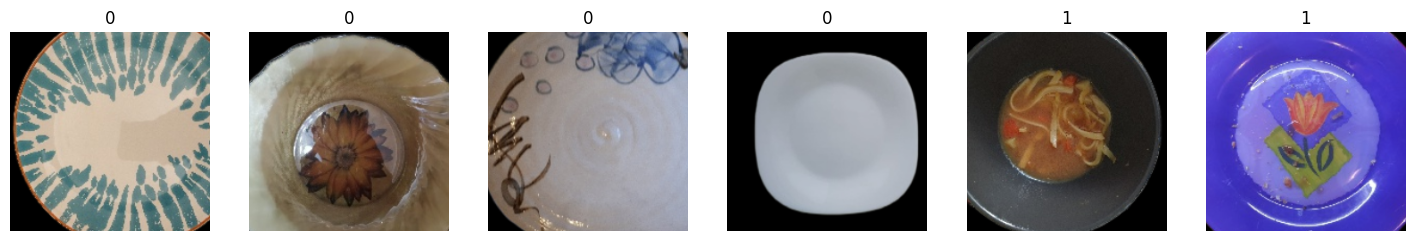

In [12]:
get_image_and_label_batch(val_dataloader, 6)

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [14]:
def train_model(model, train_dataloader, val_dataloader, loss, optimizer, num_epochs, early_stop_tolerance=5, scheduler=None, verbose=True):
    loss_train_history = []
    acc_train_history = []
    loss_val_history = []
    acc_val_history = []
    
    early_stop_counter, best_val_loss = 0, 10 ** 5
    for epoch in range(num_epochs):
        if epoch % 5 == 0:
            print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluation mode
                
            running_loss = 0.
            running_acc = 0.
            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device).unsqueeze(1).float()

                optimizer.zero_grad()
                
                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    
                    preds_class = torch.where(preds > 0, 1.0, 0.0)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()
                        if scheduler is not None:
                            scheduler.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean().item()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            if (phase=='train'):
                loss_train_history.append(epoch_loss)
                acc_train_history.append(epoch_acc)
            elif (phase=='val'):
                loss_val_history.append(epoch_loss)
                acc_val_history.append(epoch_acc)
                
                if epoch_loss > best_val_loss:
                    early_stop_counter += 1
                    if early_stop_counter > early_stop_tolerance:
                        return (loss_train_history, loss_val_history), (acc_train_history, acc_val_history)
                else:
                    early_stop_counter = 0
                    best_val_loss = epoch_loss


            if phase == 'val' and epoch % 5 == 0 and verbose:
                print('Train loss: {:.4f} acc: {:.4f} | Val loss: {:.4f} acc: {:.4f}'.format(loss_train_history[-1], acc_train_history[-1], 
                                                                                            loss_val_history[-1], acc_val_history[-1]), flush=True)
            
    return (loss_train_history, loss_val_history), (acc_train_history, acc_val_history)

In [15]:
from matplotlib import pyplot as plt

def show_history(loss_history, accuracy_history):
    plt.plot(loss_history[0], label="train loss") # train loss
    plt.plot(loss_history[1], label="validation loss") # validation loss
    plt.title("Loss History")
    plt.legend()
    plt.show()
    plt.plot(accuracy_history[0], label="train acc") # train accuracy
    plt.plot(accuracy_history[1], label="validation acc") # validation accuracy
    plt.title("Accuracy history")
    plt.legend()
    plt.show()

In [16]:
from torchvision import models
from torch import nn


model = models.resnet152(weights="IMAGENET1K_V2")
# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False
# initialising new fc layer
model.fc = nn.Sequential(
                         nn.Linear(model.fc.in_features, 400),
                         nn.ReLU(),
                         nn.Dropout(0.25),
                         nn.Linear(400,1)
                        )
model = model.to(device)

loss = torch.nn.BCEWithLogitsLoss()


optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=0.0003) 

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:01<00:00, 148MB/s]


In [17]:
loss_hist, acc_hist = train_model(model, train_dataloader, val_dataloader, loss, optimizer,
                                  num_epochs=200, early_stop_tolerance=7)

Epoch 0/199:
Train loss: 0.6898 acc: 0.5938 | Val loss: 0.6892 acc: 0.5000
Epoch 5/199:
Train loss: 0.5771 acc: 0.9688 | Val loss: 0.6552 acc: 0.7500
Epoch 10/199:
Train loss: 0.4529 acc: 0.9688 | Val loss: 0.6157 acc: 0.8750
Epoch 15/199:
Train loss: 0.3337 acc: 0.9375 | Val loss: 0.5596 acc: 0.8750
Epoch 20/199:
Train loss: 0.2623 acc: 0.9375 | Val loss: 0.5363 acc: 0.7500
Epoch 25/199:
Train loss: 0.1745 acc: 1.0000 | Val loss: 0.5451 acc: 0.7500


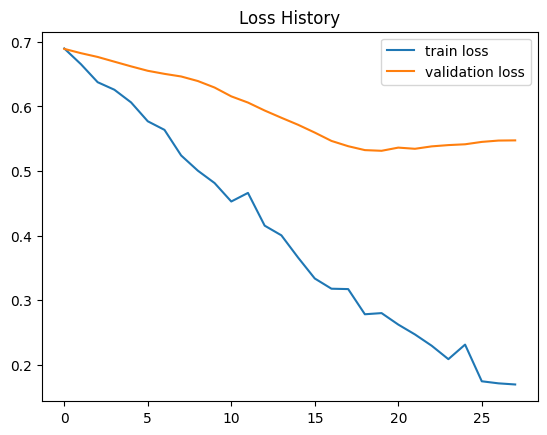

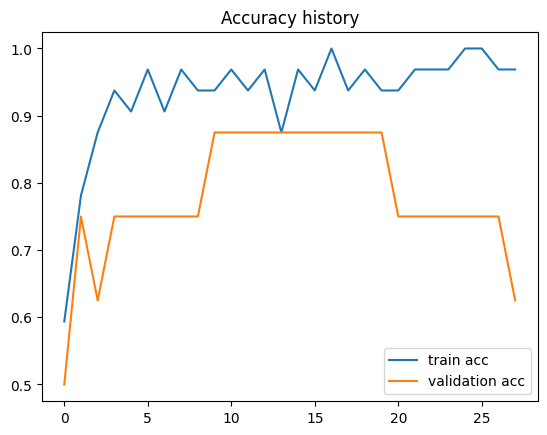

In [18]:
show_history(loss_hist, acc_hist)

In [19]:
model.eval()

test_predictions = np.array([])
for inputs, _ in tqdm(test_dataloader):
    inputs = inputs.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions = np.concatenate((test_predictions, np.squeeze(torch.sigmoid(preds).cpu().numpy())))

100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


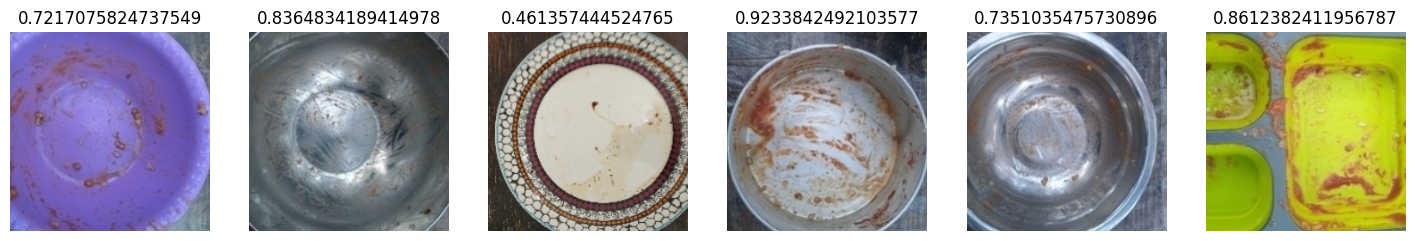

In [20]:
get_image_and_label_batch(test_dataloader, 6, labels=test_predictions)

In [21]:
labels = ['dirty' if x > 0.5 else 'cleaned' for x in test_predictions]
submission_df = pd.read_csv('/kaggle/input/platesv2/sample_submission.csv')
submission_df['label'] = labels
submission_df

,id,label
0,0,dirty
1,1,dirty
2,2,cleaned
3,3,dirty
4,4,dirty
...,...,...
739,739,dirty
740,740,dirty
741,741,cleaned
742,742,dirty


In [22]:
submission_df.to_csv('submission.csv', index=False)

In [23]:
!rm -rf train val test plates